# Libraries

In [1]:
library(tidyverse)
library(dagitty)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Question

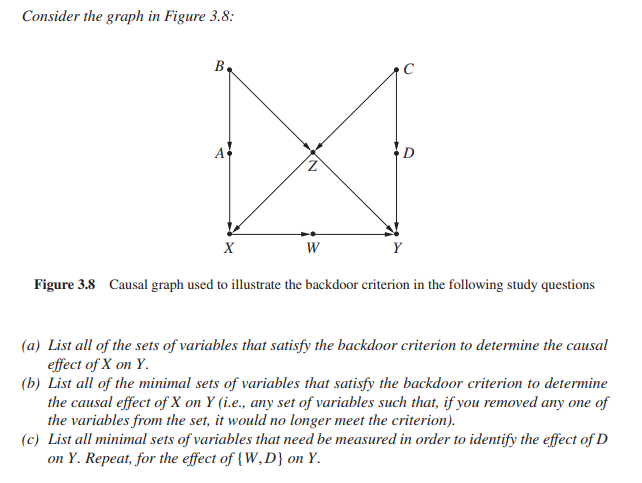

# Solution

Get the DAG:

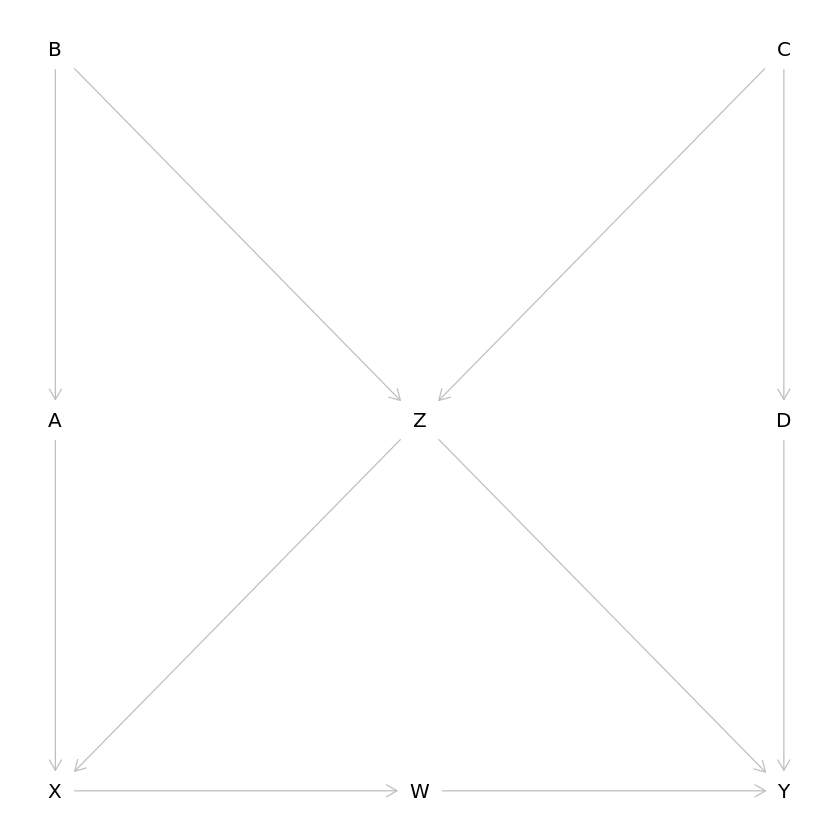

In [2]:
g <- downloadGraph("dagitty.net/m331")
plot(g)

## (a)

Recall definition 3.3.1 (The Backdoor Criterion):

The set of variables $Z$ that meet the backdoor criterion given an ordered pair of variables $(X, Y)$ must have the following properties:

* no node in $Z$ is a descendant of $X$
* $Z$ blocks every path between $X$ and $Y$ that contains an **arrow into $X$**

In [3]:
adjs <- adjustmentSets(g, "X", "Y", type="all" )
soln_lengths <- map_int(adjs, length) %>%
    unique

print(soln_lengths)

[1] 2 3 4 5


In [4]:
get_solutions_of_length <- function(n)
    adjs %>%
        keep(~length(.x) == n)

In [5]:
display_solution <- function(n) {
    soln <- get_solutions_of_length(n)
    message(str_interp("Solution of length ${n}"))
    walk(soln, ~ cat(.x, "\n"))
}

In [6]:
walk(soln_lengths, display_solution)

Solution of length 2



A Z 
B Z 
C Z 
D Z 


Solution of length 3



A B Z 
A C Z 
B C Z 
A D Z 
B D Z 
C D Z 


Solution of length 4



A B C Z 
A B D Z 
A C D Z 
B C D Z 


Solution of length 5



A B C D Z 


For reference, look at all the open paths:

In [7]:
p <- paths(g, "X", "Y")
map2(p$paths, p$open, ~ list(path=.x, is_open=.y)) %>%
    keep(~.x$is_open) %>%
    map(~.x$path)

[[1]]
[1] "X -> W -> Y"

[[2]]
[1] "X <- A <- B -> Z -> Y"

[[3]]
[1] "X <- Z -> Y"

[[4]]
[1] "X <- Z <- C -> D -> Y"

The closed paths:

In [8]:
p <- paths(g, "X", "Y")
map2(p$paths, p$open, ~ list(path=.x, is_open=.y)) %>%
    keep(~!(.x$is_open)) %>%
    map(~.x$path)

[[1]]
[1] "X <- A <- B -> Z <- C -> D -> Y"

Check the decendants of X:

In [9]:
# all the vars that are reachable from X via a directed path
descendants(g, "X") %>%
    setdiff(c("X", "Y"))

[1] "W"

## (b)

In [10]:
# This works because the exposure variable X and the outcome variable Y have already been specified in the graph.
adjustmentSets(g)

{ D, Z }
{ C, Z }
{ B, Z }
{ A, Z }

## (c)

The effect of $D$ on $Y$ means $D$ is the exposure and $Y$ is the outcome.

Change the exposure of the graph:

In [11]:
exposures(g)

[1] "X"

In [12]:
exposures(g) <- c("D")
exposures(g)

[1] "D"

In [13]:
adjustmentSets(g)

{ W, Z }
{ X, Z }
{ A, Z }
{ B, Z }
{ C }

The effect of of $\{W, D\}$ on $Y$:

In [14]:
# instead of modifying the graph, we can set the outcomes and exposures in the function itself
adjustmentSets(g, exposure=c("W", "D"), outcome=c("Y"))

{ Z }
{ C, X }

In [15]:
# the exposure is still D
exposures(g)

[1] "D"

The open paths:

In [16]:
p <- paths(g, from = "D", to = "Y")
map2(p$paths, p$open, ~ list(path=.x, is_open=.y)) %>%
    keep(~.x$is_open) %>%
    map(~.x$path)

[[1]]
[1] "D -> Y"

[[2]]
[1] "D <- C -> Z -> X -> W -> Y"

[[3]]
[1] "D <- C -> Z -> Y"

In [17]:
p <- paths(g, from = "W", to = "Y")
map2(p$paths, p$open, ~ list(path=.x, is_open=.y)) %>%
    keep(~.x$is_open) %>%
    map(~.x$path)

[[1]]
[1] "W -> Y"

[[2]]
[1] "W <- X <- A <- B -> Z -> Y"

[[3]]
[1] "W <- X <- Z -> Y"

[[4]]
[1] "W <- X <- Z <- C -> D -> Y"

The closed paths:

In [18]:
p <- paths(g, from = "D", to = "Y")
map2(p$paths, p$open, ~ list(path=.x, is_open=.y)) %>%
    keep(~!(.x$is_open)) %>%
    map(~.x$path)

[[1]]
[1] "D <- C -> Z <- B -> A -> X -> W -> Y"

In [19]:
p <- paths(g, from = "W", to = "Y")
map2(p$paths, p$open, ~ list(path=.x, is_open=.y)) %>%
    keep(~!(.x$is_open)) %>%
    map(~.x$path)

[[1]]
[1] "W <- X <- A <- B -> Z <- C -> D -> Y"

Because we also condition on $D$ and $W$, the path where is a collider remains closed!

In [20]:
p <- paths(g, from = "W", to = "Y", Z = "D")
map2(p$paths, p$open, ~ list(path=.x, is_open=.y)) %>%
    keep(~!(.x$is_open)) %>%
    map(~.x$path)

[[1]]
[1] "W <- X <- A <- B -> Z <- C -> D -> Y"

[[2]]
[1] "W <- X <- Z <- C -> D -> Y"

Conditioning on $Z$ makes the collider path open:

In [21]:
p <- paths(g, from = "W", to = "Y", Z="Z")
map2(p$paths, p$open, ~ list(path=.x, is_open=.y)) %>%
    keep(~(.x$is_open)) %>%
    map(~.x$path)

[[1]]
[1] "W -> Y"

[[2]]
[1] "W <- X <- A <- B -> Z <- C -> D -> Y"

But conditioning on $D$ too makes the path closed:

In [22]:
p <- paths(g, from = "W", to = "Y", Z=c("Z","D") )
map2(p$paths, p$open, ~ list(path=.x, is_open=.y)) %>%
    keep(~(.x$is_open)) %>%
    map(~.x$path)

[[1]]
[1] "W -> Y"

And vice versa:

In [23]:
p <- paths(g, from = "D", to = "Y", Z="Z" )
map2(p$paths, p$open, ~ list(path=.x, is_open=.y)) %>%
    keep(~(.x$is_open)) %>%
    map(~.x$path)

[[1]]
[1] "D -> Y"

[[2]]
[1] "D <- C -> Z <- B -> A -> X -> W -> Y"

In [24]:
p <- paths(g, from = "D", to = "Y", Z=c("Z","W") )
map2(p$paths, p$open, ~ list(path=.x, is_open=.y)) %>%
    keep(~(.x$is_open)) %>%
    map(~.x$path)

[[1]]
[1] "D -> Y"